In [1]:
import argparse
import gym
import random
import copy 
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from drawnow import drawnow
import matplotlib.pyplot as plt

from collections import deque

#from ride_hailing_env import RideHailingENV

import folium

C:\Users\zhh\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Developing Notes:

1) the obsevration dimension should be set as fixed, it can be the number of drivers/riders in each cell,
    this will result in a observation space of 48*2 dimension.

2) Dimension number  is important, converange is good when cell number is 4, not good when cell number is 30+, try to reduce cell number.

### Data Norm and Standardarize

下一步代码， 一个critic多个actor

In [36]:
"""
# Ride_hailing env
This is the file for defining the simulator for the ride-hailing environment.
Functions defined in this file can be used for reinforcement learning.
This is part of the master thesis project:
Optimising matching radius for a ride-hailing system.

# Use this .py script:
env = RideHailingENV(grid_div=2)
ob_rider, ob_driver, done = env.reset()
ob_rider, ob_driver, reward = env.step(action, time_step, rend_step=False)

# Test this environment for one step:
env = RideHailingENV(grid_div=2)
ob_rider, ob_driver, done = env.reset()
action = np.full(4, 800)
ob_rider, ob_driver, reward, done = env.step(action, hr_time=1, rend_step=True)
print(reward, done)

# Test this environment for one episode (5 hours):
env = RideHailingENV(grid_div=2)
ob_rider, ob_driver, done = env.reset()
time_step, ep_reward, step_count = 1, 0, 0
action = np.full(4, 800)
while not done:
    ob_rider, ob_driver, reward, done = env.step(action, time_step, rend_step=False)
    ep_reward += reward
    step_count += 1
print(f'{ep_reward} | {step_count}')
"""


import gym
import folium

import numpy as np
import pandas as pd

from h3 import h3
from gym import spaces
from folium.features import DivIcon
from IPython.display import display
from ride_hailing_match import Match
from ride_hailing_location_model import Build_Model
from pyproj import Transformer


def wgs84_to_xy(x_arr: np.ndarray, y_arr: np.ndarray):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32614')
    x0 = 604082.94
    y0 = 3328141.76
    x_arr_new, y_arr_new = transformer.transform(x_arr, y_arr)
    x_arr_new -= x0
    y_arr_new -= y0
    return x_arr_new.tolist(), y_arr_new.tolist()

def xy_to_wgs84(xy_list):
    transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326')
    x_new = np.array(xy_list[0]) + 604082.94
    y_new = np.array(xy_list[1]) + 3328141.76
    lat_lon = transformer.transform(x_new, y_new)
    return lat_lon

def xy_to_wgs84_list(xy_list):
    transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326')
    x_arr = np.array(xy_list[0]) + 604082.94
    y_arr = np.array(xy_list[1]) + 3328141.76
    lat_list, lon_list = transformer.transform(x_arr, y_arr)
    return lat_list.tolist(), lon_list.tolist()


class Cell:
    """Gennerate cells
    """
    def __init__(self, num_divisions) -> None:
        self.lat_range = np.array([30.18, 30.32]) # Austin latitude range
        self.lon_range = np.array([-97.81, -97.65]) # Austin longitude range
        self.x_range, self.y_range = wgs84_to_xy(self.lat_range, self.lon_range)
        self.num_divisions = num_divisions # how many part lat and lon are divided
        pass
   
    def pass_info(self):
        return self.lat_range, self.lon_range, self.x_range, self.y_range, self.num_divisions
    
    def get_cells(self, display_map: bool = False) -> list:
        number =  self.num_divisions ** 2
        cells = np.arange(number)

        if display_map == False:
            return cells
        
        else:
            self.draw_cell()
            return cells
        
    def draw_cell(self, state: np.array = None, radius_set: np.array = None):
        # generate step data
        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        m = folium.Map(location=[(self.lat_range[0] + self.lat_range[1]) / 2, (self.lon_range[0] + self.lon_range[1]) / 2], zoom_start=13)

        for i in range(self.num_divisions):
            for j in range(self.num_divisions):
                lat_start = self.lat_range[0] + i * lat_step
                lat_end = lat_start + lat_step
                lon_start = self.lon_range[0] + j * lon_step
                lon_end = lon_start + lon_step
                grid_number = i * self.num_divisions + j

                # Draw the grid
                folium.Rectangle(
                    bounds=[[lat_start, lon_start], [lat_end, lon_end]],
                    color='blue',
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)

                # Add grid label
                if state is None:
                    folium.Marker(
                        location=[lat_end-0.001, lon_start+0.002],
                        popup=folium.Popup('<i>The center of map</i>'),
                        tooltip='Center',
                        icon=folium.DivIcon(html=f"""<b>Cell ID: {grid_number}</b>""",
                                    class_name="mapText"),
                        ).add_to(m)
                else:
                    rider_count = int(state[grid_number * 2] * 50)
                    driver_count = int(state[grid_number * 2 + 1] * 50)
                    folium.Marker(
                        location=[lat_end-0.001, lon_start+0.002],
                        popup=folium.Popup('<i>The center of map</i>'),
                        tooltip='Center',
                        icon=folium.DivIcon(html=f'<b>Cell ID: {grid_number}<br>Rider Number: {rider_count}<br>Driver Number: {driver_count}</b>',
                                    class_name="mapText"),
                        ).add_to(m)
                
                m.get_root().html.add_child(folium.Element("""<style>.mapText {
                        white-space: nowrap;
                        color:Green;
                        font-size:large
                    }</style>"""))

                # Draw radius if radius_set is provided
                if radius_set is not None and grid_number < len(radius_set):
                    radius = radius_set[grid_number]
                    folium.Circle(
                        location=[(lat_start + lat_end) / 2, (lon_start + lon_end) / 2],
                        radius=radius,
                        color='red',
                        fill=True,
                        fill_opacity=0.3
                    ).add_to(m)

        display(m)

    def get_cell_id_wgs84(self, lat, lon):
        if not (self.lat_range[0] <= lat <= self.lat_range[1]) or not (self.lon_range[0] <= lon <= self.lon_range[1]): # check if in the range
            return None
        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        lat_index = min(int((lat - self.lat_range[0]) / lat_step), self.num_divisions - 1)
        lon_index = min(int((lon - self.lon_range[0]) / lon_step), self.num_divisions - 1)
        grid_number = lat_index * self.num_divisions + lon_index
        return grid_number
    
    def get_cell_id_xy(self, x_list, y_list):
        cell_ids = []
        x_step = (self.x_range[1] - self.x_range[0]) / self.num_divisions
        y_step = (self.y_range[1] - self.y_range[0]) / self.num_divisions

        for x, y in zip(x_list, y_list):
            x_index = min(int((x - self.x_range[0]) / x_step), self.num_divisions - 1)
            y_index = min(int((y - self.y_range[0]) / y_step), self.num_divisions - 1)
            grid_number = x_index + y_index * self.num_divisions
            cell_ids.append(grid_number)
        
        return cell_ids
        

class Gen_Model:
    """Sample locations from fitted model for riders and drivers in the map

    This class is to generate locations for riders and drivers based on the given
    distribution of their locations. This default model is estimated with Kernel 
    Density Estimation (KDE). The generated location is given in the format of 
    a pandas DataFrame, each row represents a unique rider/driver. Information
    given in a row includes rider/driver's ID, H3 code, longitude and latitude.

    Attributes:
        model: an instance of Build_Model class containing models for riders and drivers
        rider_model: a dictionary for 24 KDE distributions, describing the locational and timely distribution of riders
        driver_model: a dictionary for 24 KDE distributions, describing the locational and timely distribution of drivers
    """
    def __init__(self, num_div) -> None:
        self.cell = Cell(num_div)
        self.cell_ids = self.cell.get_cells(False)
        self.model = Build_Model()
        self.rider_model, self.driver_model = self.model.get_model()

    def gen_drivers(self, number_of_drivers: int, hr_time: int, seed: int = None):
        """Sample locations for drivers
        
        Sample multiple locations for drivers based on the given locational distribution 
        of drivers. The default distribution model is KDE.

        Parameters:
            number_of_drivers: an int, indicating how many drivers are generated.
            hr_time: an int, the value is the hour of the day, indicating which distribution model will be used.
            resolution: an int, determines the number of cells in the map.

        Returns:
            driver_df: a pandas DataFrame, including information of generated drivers. 
        """
        if seed != None:
            driver_locations = self.model.sample_from_model(self.driver_model[f'{hr_time}'], number_of_drivers, seed) # dtype = numpy ndarray
        else:
            driver_locations = self.model.sample_from_model(self.driver_model[f'{hr_time}'], number_of_drivers) # dtype = numpy ndarray
        driver_ids = []
        cell_ids = []

        for driver_id, geo_info in enumerate(driver_locations):
            cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
            while cell_id is None:
                geo_info = self.model.sample_from_model(self.rider_model[f'{hr_time}'], 1)[0] # dtype = numpy ndarray
                cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
                driver_locations[driver_id] = geo_info
                #print('Re-sampled a driver!')
            cell_ids.append(cell_id)
            driver_ids.append(driver_id)

        x_list, y_list = wgs84_to_xy(driver_locations.T[0], driver_locations.T[1])

        driver_df = pd.DataFrame({'driver_id':driver_ids, 'cell_id':cell_ids, 'x':x_list, 'y':y_list, 'statue': 1, 'idle_time': 0})
        # driver is avliable: 'statue' = 1, unavliable: 'statue' = 0
        # driver_df[['driver_id', 'cell_id']] = driver_df[['driver_id', 'cell_id']].astype(int) # set data type to int

        return driver_df

    def gen_riders(self, number_of_riders: int, hr_time: int, seed: int = None):
        """Sample locations for riders
        
        Sample multiple locations for riders based on the given locational distribution 
        of riders. The default distribution model is KDE.

        Parameters:
            number_of_riders: an int, indicating how many riders are generated.
            hr_time: an int, the value is the hour of the day, indicating which distribution model will be used.
            resolution: an int, determines the number of cells in the map.

        Returns:
            rider_df: a pandas DataFrame, including information of generated riders. 
        """
        if seed != None:
            rider_locations = self.model.sample_from_model(self.rider_model[f'{hr_time}'], number_of_riders, seed) # dtype = numpy ndarray
        else:
            rider_locations = self.model.sample_from_model(self.rider_model[f'{hr_time}'], number_of_riders) # dtype = numpy ndarray
        rider_ids = []
        cell_ids = []
        
        for rider_id, geo_info in enumerate(rider_locations):
            cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
            while cell_id is None:
                geo_info = self.model.sample_from_model(self.rider_model[f'{hr_time}'], 1)[0] # dtype = numpy ndarray
                cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
                rider_locations[rider_id] = geo_info
                #print('Re-sampled a rider!')
            cell_ids.append(cell_id)
            rider_ids.append(rider_id)

        x_list, y_list = wgs84_to_xy(rider_locations.T[0], rider_locations.T[1])

        rider_df = pd.DataFrame({'rider_id':rider_ids, 'cell_id':cell_ids, 'x':x_list, 'y':y_list, 'time_step_in_pool': 1})
        # rider_df[['rider_id', 'cell_id', 'time_step_in_pool']] = rider_df[['rider_id', 'cell_id', 'time_step_in_pool']].astype(int) # set data type to int

        return rider_df


class RideHailingENV(gym.Env):
    """Simulation environment for project optimising matching radius for ride-hailing system

    This class is the main simulator for the master thesis project optimising matching radius 
    for a ride-hailing system with reinforcement learning. The project is carried out in TU Delft. 
    This simulator is built base on the geographical information of Austin, Texas, USA. It intake
    continous matching radius as the action, and the reward is the total net profit made by the 
    system within a day.

    GOOD action for example:
    action = np.ones(36)*800
    action[[5, 13, 14, 15, 19, 20, 21, 26, 27]] = 400

    Attributes:
     lower_bound - lower bound of action space, minimum matching radius, unit is meters.
     upper_bound - upper bound of action space, maximum matching radius, unit is meters.
     model - make an instance of Gen_Model class, to generate riders and drivers for the simulator.
     match - make an instance of Match class, to run the matching algorithm.
     radius_initial - initial matching radius when reset the environment, unit is meters.
     driver_num_ini - initial number of drivers, can be changed if set dynamic.
     rider_num_ini - initial number of riders, rider number is changing among different steps.
     fuel_unit_price - average travelling fuel cost per vehicle per kilometer in the US, the unit is US dollars.
     time_window - time interval between every two matching process (Uber Batched matching), fixed among all steps, unit is minutes.
     total_reward - total reward for the intake action.
     gen_rate_rider - overall generating rate of riders, number of riders per time-window.
     gen_rate_driver - active if vehicle number are set dynamic, number of new drivers per time-window.
     ride_price - average ride price in Austin urban area, the value is estimated from Uber ride data in 2022.
     rider_patience - the maximum number of steps a rider can stay in the matching pool.
     p_unmatch_rider - penalty per unmatched rider, the value is cauculated base on the probability of losing a potential ride.
     action_space - defines the numerical range of intake actions.
     observation_space - defines the numerical range of overall observations.
     sub_observation_space - defines the numerical range of observations within a cell.

    Distance cost explain:
     distance cost = car-buying cost + car repair and maintanance cost + fuel cost
     car repair and maintanance cost = change tire per 200000km &1000 + change motor oil per 200000km $1200
     car-buying cost: average car price in the us is $22000
     fuel cost: averge fuel cost $1.3/L * averge fuel comsuption 9.3L/100km = $12.1/100km = $0.12/km
     total = $11.65/km
    """
    def __init__(self, grid_div, time_window: int = 0.25) -> None:

        self.min_action = 50
        self.max_action = 3000
        self.num_divi = grid_div
        self.cell = Cell(self.num_divi)
        self.lat_range, self.lon_range, self.x_range, self.y_range, self.num_divisions = self.cell.pass_info()
        self.model = Gen_Model(self.num_divi)
        self.match = Match()
        self.seed_ini = None

        self.cell_ids = self.cell.get_cells(False)
        self.cell_num = np.size(self.cell_ids)
        self.radius_initial = 500
        self.driver_num_ini = 40
        self.rider_num_ini = 40
        self.time_window = time_window
        self.total_reward = 0
        self.gen_rate_rider = 20
        self.gen_rate_driver = 10
        self.rider_patience = 0.75 # minutes
        self.p_rider_left = 0.1 # punishment
        self.p_unmatch_rider = 5
        self.simulation_time = 60

        self.drivers = None
        self.riders = None
        self.drivers_tmp = None
        self.riders_tmp = None

        self.rider_patience_step = self.rider_patience / self.time_window

        self.action_dim = self.cell_num
        self.state_dim = self.cell_num*2

        self.max_step = self.simulation_time / self.time_window
        self.axis = (self.min_action + self.max_action) / 2
        self.scale = (self.max_action - self.min_action) / 2
        self.multi_task_weight_factor = [0.4, 0.4, 0.2]
        self.score_distance = lambda distance, max_distance=2000: max(0, min(1, distance / max_distance))
        self.score_radius = lambda distance, max_distance=2500: max(0, min(1, 1- distance / max_distance))

    def reset(self, time_ini: int = 1) -> np.array:
        self.random_seed = self.seed_ini
        self.drivers = self.model.gen_drivers(self.driver_num_ini, time_ini, self.random_seed)
        self.drivers_in_service = np.zeros(self.driver_num_ini, dtype=np.int32)
        self.drivers['driver_id'] = np.arange(self.drivers.shape[0])
        self.riders = self.model.gen_riders(self.rider_num_ini, time_ini, self.random_seed)
        self.riders['rider_id'] = np.arange(self.riders.shape[0])
        self.rider_0, self.driver_0 = self.get_observe()
        rider, driver = self.rider_0/self.driver_num_ini, self.driver_0/self.driver_num_ini # normalize
        state_0 = np.empty(rider.size + driver.size, dtype=rider.dtype)
        state_0[0::2] = rider
        state_0[1::2] = driver
        self.on_goal = 0
        self.reward_ini(self.rider_0, self.driver_0)
        state = state_0
        self.step_count = 0
        return state
    
    def min_max(self, action):
        radius = action * self.scale + self.axis
        return radius
        
    def step(self, action: np.array, hr_time: int, rend_step: bool = False, min_max: bool = True) -> tuple[float, dict, list]:
        if min_max == True:
            radius = self.min_max(action)
        else:
            radius = action
        self.riders_tmp = self.riders.copy()
        self.drivers_tmp = self.drivers.copy()

        cell_ids = self.riders['cell_id']
        r_radius = radius[cell_ids]

        # get the matching pool
        pool = self.__get_pool(self.dis_matrix, r_radius)

        # matching process
        match_statue = self.__match(pool)
        _ = self.__execute_match(match_statue, pool, radius)

        if match_statue:
            aver_distance = sum(distance for _, _, distance in match_statue) / len(match_statue)
            reward_match_rate = len(match_statue) / len(self.rider_0)
            reward_driver_ult = len(match_statue) / len(self.driver_0)
        else:
            aver_distance = 0 
            reward_match_rate = 0
            reward_driver_ult = 0
        reward = (reward_match_rate * self.multi_task_weight_factor[0] + 
                  self.score_distance(aver_distance) * self.multi_task_weight_factor[1] + 
                  reward_driver_ult * self.multi_task_weight_factor[2])
        reward, done = self.train_radius_reward(radius)
        
        if rend_step:
            state = [self.riders_tmp, self.drivers_tmp]
            self.render(state, radius, match_statue)

        self.riders, self.drivers = self.__state_transit(hr_time, match_statue)
        rider, driver = self.get_observe()
        self.rider_0, self.driver_0 = rider, driver
        self.reward_ini(self.rider_0, self.driver_0)
        rider, driver = rider/self.driver_num_ini, driver/self.driver_num_ini # normalize
        state_0 = np.empty(rider.size + driver.size, dtype=rider.dtype)
        state_0[0::2] = rider
        state_0[1::2] = driver
        state = state_0

        return state, reward, done
    
    def reward_ini(self, riders, drivers):
        total = riders + drivers
        rider_ratio = riders / (total + 1e-6)
        driver_ratio = drivers / (total + 1e-6)
        sigmoid_rider_ratio = 1 / (1 + np.exp(-10 * (rider_ratio - 1.75*self.multi_task_weight_factor[0]))) 
        sigmoid_driver_ratio = 1 / (1 + np.exp(-10 * (driver_ratio - 1.75*self.multi_task_weight_factor[1])))
        self.reward = self.min_action + (self.max_action - self.min_action) * (1 + sigmoid_rider_ratio - sigmoid_driver_ratio) / 2
        pass

    def train_radius_reward(self, action):
        done = False
        normalized_reward = (action - self.reward) / self.scale
        score = 1 - np.abs(normalized_reward)
        score = np.clip(score, -1, 1)
        reward = score - 1
        reward[score >= 0.95] += 1
        return reward, done
    
    def test_step(self, action: np.array, hr_time: int, rend_step: bool = False, min_max: bool = True) -> tuple[float, dict, list]:
        if min_max == True:
            radius = self.min_max(action)
        else:
            radius = action
        self.riders_tmp = self.riders.copy()
        self.drivers_tmp = self.drivers.copy()
        rider_0, driver_0 = self.get_observe()
        cell_ids = self.riders['cell_id']
        r_radius = radius[cell_ids]
        # get the matching pool
        pool = self.__get_pool(self.dis_matrix, r_radius)
        # matching process
        match_statue = self.__match(pool)
        self.__execute_match(match_statue, pool, radius)
        if match_statue:
            aver_distance = sum(distance for _, _, distance in match_statue) / len(match_statue)
            reward_match_rate = len(match_statue) / len(rider_0)
            reward_driver_ult = len(match_statue) / len(driver_0)
        else:
            aver_distance = 0 # in case for tricky policies
            reward_match_rate = 0
            reward_driver_ult = 0
        self.riders, self.drivers = self.__state_transit(hr_time, match_statue)
        #reward_distance = aver_distance / self.max_action
        reward_distance = self.score_distance(aver_distance)
        #radius_avg = sum(radius)/self.cell_num
        performance = reward_match_rate * self.multi_task_weight_factor[0] + self.score_radius(sum(radius)/self.cell_num) * self.multi_task_weight_factor[1] # + reward_driver_ult * self.multi_task_weight_factor[2]
        #performance -= (1 + np.exp(-0.04 * (radius - self.min_action))) * (1 + np.exp(0.005 * (radius - self.max_action))) - 1
        rider, driver = self.get_observe()
        self.rider_0, self.driver_0 = rider, driver
        rider, driver = rider/self.driver_num_ini, driver/self.driver_num_ini # normalize
        state_0 = np.empty(rider.size + driver.size, dtype=rider.dtype)
        state_0[0::2] = rider
        state_0[1::2] = driver
        state = state_0
        return state, performance, False
    
    def test_detail(self, action: np.array, hr_time: int, rend_step: bool = False, min_max: bool = True) -> tuple[float, dict, list]:
        if min_max == True:
            radius = self.min_max(action)
        else:
            radius = action
        self.riders_tmp = self.riders.copy()
        self.drivers_tmp = self.drivers.copy()
        rider_0, driver_0 = self.get_observe()
        cell_ids = self.riders['cell_id']
        r_radius = radius[cell_ids]
        # get the matching pool
        pool = self.__get_pool(self.dis_matrix, r_radius)
        # matching process
        match_statue = self.__match(pool)
        self.__execute_match(match_statue, pool, radius)
        if match_statue:
            aver_distance = sum(distance for _, _, distance in match_statue) / len(match_statue)
            reward_match_rate = len(match_statue) / len(rider_0)
            reward_driver_ult = len(match_statue) / len(driver_0)
        else:
            aver_distance = 0 # in case for tricky policies
            reward_match_rate = 0
            reward_driver_ult = 0
        self.riders, self.drivers = self.__state_transit(hr_time, match_statue)
        #reward_distance = aver_distance / self.max_action
        reward_distance = self.score_distance(aver_distance)
        #radius_avg = sum(radius)/self.cell_num
        performance = np.array([reward_match_rate, aver_distance, reward_driver_ult])
        #performance -= (1 + np.exp(-0.04 * (radius - self.min_action))) * (1 + np.exp(0.005 * (radius - self.max_action))) - 1
        rider, driver = self.get_observe()
        self.rider_0, self.driver_0 = rider, driver
        rider, driver = rider/self.driver_num_ini, driver/self.driver_num_ini # normalize
        state_0 = np.empty(rider.size + driver.size, dtype=rider.dtype)
        state_0[0::2] = rider
        state_0[1::2] = driver
        state = state_0
        return state, performance, False
    
    def get_observe(self): # observation is number of riders/drivers in each cell
        rider_counts = self.riders['cell_id'].value_counts().sort_index().reindex(range(self.cell_num), fill_value=0).to_numpy()
        supply_driver = self.drivers[self.drivers['statue']==1]
        supply_driver = self.drivers
        driver_counts = supply_driver['cell_id'].value_counts().sort_index().reindex(range(self.cell_num), fill_value=0).to_numpy()

        #avg_distance = np.full(self.cell_num, 3000)  # Initialize with 6000 for cells with no riders
        rider_vec = self.riders[['x', 'y']].values
        driver_vec = self.drivers[['x', 'y']].values
        self.dis_matrix = self.__vector_dis(rider_vec, driver_vec)
        """
        for cell_id in range(self.cell_num):
            riders_in_cell = self.riders[self.riders['cell_id'] == cell_id].index
            if len(riders_in_cell) > 0:
                distances = self.dis_matrix[riders_in_cell].min(axis=1)
                distance = distances.mean()
                avg_distance[cell_id] = distance
        avg_distance = np.clip(avg_distance, 0, 3000)"""
        return rider_counts, driver_counts#, avg_distance
    
    def check_done(self):
        if self.step_count >= self.max_step -1: #or self.riders.shape[0] == 0:
            done = True
        else:
            done = False
        return done

    def __get_pool(self, dis_matrix: list, radius_set: int) -> np.ndarray:
        """
        form a matching pool for all the riders and available drivers whithin the matching radius.

        Parameters:
            riders - locations, numbers of all the riders.
            drivers - locations, numbers of all the drivers.
            radius - matching radius for each cell, riders in the same cell have the same matching radius.

        Returns:
            returns a list consist all the possible matches and the distance between them.
        """
        match_pool = []
        for i in range(dis_matrix.shape[0]):
            sub_pool = []
            radius_rider = radius_set[i]
            driver_1 = np.where(dis_matrix[i] <= radius_rider)[1]
            driver_2 = self.drivers.index[self.drivers['statue'] == 1]
            driver = list(np.intersect1d(driver_1, driver_2))
            rider = list(np.ones(np.size(driver), dtype=int)*i)
            dis = dis_matrix[i, driver].tolist()[0]
            sub_pool.extend([rider])
            sub_pool.extend([driver])
            sub_pool.extend([dis])
            sub_pool = list(map(list, zip(*sub_pool)))
            match_pool.extend(sub_pool)
        return match_pool
            
    def __match(self, pool: list): # MM: Maximum Matching, OM: Optimised Matching
        """
        excute matching algorithm to find the optimal match for the given matching pool.

        Parameters:
         pool - matching pool with distance. 

        Returns:
         match statue with matched pairs and their distance. 
        """
        matched_pairs = self.match.match(pool, method='Munkres')
        return matched_pairs
    
    def __execute_match(self, match_statue:list, match_pool: list, radius: np.array) -> tuple[float, tuple]:
        """
        apply the matched pairs to the map, update riders and drivers, observe reward and penalty.

        Parameters:
        riders - locations, numbers of all the riders.
        drivers - locations, numbers of all the drivers.
        match_statue - matched pair of riders and drivers with the distance between them.

        Returns:
        reward - the net monetary profit made from the ride-hailing system within a step.
        pool_next - next state of the environment after taking the action.
        """
        # calculate total distance and rewards
        reward = 0 #- 200 * self.distance_cost

        if match_statue:
            #aver_distance = sum(distance for _, _, distance in match_statue) / len(match_statue)
            riders_to_drop, drivers_to_drop = zip(*[(rider, driver) for rider, driver, _ in match_statue])
            riders_to_drop, drivers_to_drop = list(riders_to_drop), list(drivers_to_drop)
        else:
            #aver_distance = 0 # in case for tricky policies
            riders_to_drop, drivers_to_drop = [], []
                 
        #reward_distance = self.score_distance(aver_distance)

        #print(complete_rate, reward_distance, reward_driver_ult)

        #reward = complete_rate * self.multi_task_weight_factor[0] + reward_distance * self.multi_task_weight_factor[1] + reward_driver_ult * self.multi_task_weight_factor[2]
        #reward = complete_rate * self.multi_task_weight_factor[0] - self.score_radius(sum(radius) / self.cell_num) * self.multi_task_weight_factor[1]

        self.riders = self.riders.drop(riders_to_drop)
        self.drivers_in_service[drivers_to_drop] += 2
        self.drivers.loc[drivers_to_drop, 'statue'] = 0
        self.drivers.loc[drivers_to_drop, 'idle_time'] = 0

        self.riders['time_step_in_pool'] += 1
        #reward -= self.p_rider_left * self.riders[self.riders['time_step_in_pool']>self.rider_patience].shape[0]

        return 0
    
    def __vector_dis(self, rider_vec, driver_vec):
        m = np.shape(rider_vec)[0]
        n = np.shape(driver_vec)[0]
        M = np.dot(rider_vec, driver_vec.T)
        H = np.tile(np.matrix(np.square(rider_vec).sum(axis=1)).T,(1,n))
        K = np.tile(np.matrix(np.square(driver_vec).sum(axis=1)),(m,1))
        return np.sqrt(-2 * M + H + K)
    
    def __state_transit(self, hr_time: int, match_statue: list) -> dict: 
        """
        update the current state and give the state of the next step.
        v1_update: do not gennerate new riders, terminal is all the riders are matched or left

        Parameters:
         state - the current state, locations of riders and drivers.
         hr_time - hourly time of a day, this is used to generate new riders and drivers.

        Returns:
         returns the locations of riders and drivers for the next step.
        """
        ride_num = np.size(match_statue)

        # update riders
        
        self.riders = self.riders.drop(self.riders[self.riders['time_step_in_pool']>self.rider_patience_step].index) # inpatient riders quit the matching pool
        rider_size = self.gen_rate_rider
        new_riders = self.model.gen_riders(rider_size, hr_time, self.random_seed)
        rider_next = pd.concat((self.riders, new_riders), axis=0)

        self.drivers.loc[self.drivers_in_service == 0, 'statue'] = 1 # drivers finished ride

        # update drivers - driver reposition
        self.drivers.loc[self.drivers['statue'] == 1, 'idle_time'] += 1 # update idle time
        condition = (self.drivers['idle_time'] == 20) & (self.drivers['statue'] == 1)
        self.drivers.loc[condition, 'x'] += np.random.choice([-800, 800], size=condition.sum())
        self.drivers.loc[condition, 'y'] += np.random.choice([-800, 800], size=condition.sum())
        self.drivers.loc[condition, 'idle_time'] = 0 # reset idle time

        # update drivers - driver idling
        self.drivers_in_service[self.drivers_in_service != 0] -= 1
        self.drivers['x'] += np.random.uniform(-400, 400, size=self.drivers.shape[0])
        self.drivers['y'] += np.random.uniform(-400, 400, size=self.drivers.shape[0])

        # check latitude and longitude border
        self.drivers['x'] = np.clip(self.drivers['x'], self.x_range[0], self.x_range[1]) # check latitude range
        self.drivers['y'] = np.clip(self.drivers['y'], self.y_range[0], self.y_range[1]) # check longitude range

        # update cell ids for drivers
        self.drivers['cell_id'] = self.cell.get_cell_id_xy(self.drivers['x'], self.drivers['y']) 

        #rider_next = rider_next.reset_index(drop=True)
        self.riders = rider_next.reset_index(drop=True)
        self.drivers = self.drivers.reset_index(drop=True)

        # re-index drivers and riders
        driver_index = self.drivers.shape[0]
        self.drivers['driver_id'] = np.arange(driver_index)
        rider_index = self.riders.shape[0]
        self.riders['rider_id'] = np.arange(rider_index)

        return self.riders, self.drivers

    def render(self, state: tuple, radius_set: dict, match_statue: list, color_set: tuple = ['red', 'blue'], folium_map=None) -> None:
        """
        visualise the state and action for one step, red circle is matching range (within matching radius),
        green lines are the links for matched pairs.

        Parameters:
         state - the current state, locations of riders and drivers.
         radius_set - matching radius for each cell.
         match_statue - matched pair of riders and drivers with the distance between them.
         folium_map - map object.
        """

        riders = state[0]
        drivers = state[1]
        drivers = drivers[drivers['statue'] == 1]
        drivers.reset_index(drop=True, inplace=True)
        matched_riders = []
        matched_drivers = []
        if match_statue != []:
            matched_riders = pd.DataFrame(match_statue)[0].to_list()
            matched_drivers = pd.DataFrame(match_statue)[1].to_list()

        matched_rider_location = {}
        matched_driver_location = {}

        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        m = folium.Map(location=[(self.lat_range[0] + self.lat_range[1]) / 2, (self.lon_range[0] + self.lon_range[1]) / 2], zoom_start=13)
        for i in range(self.num_divisions):
            for j in range(self.num_divisions):
                lat_start = self.lat_range[0] + i * lat_step
                lat_end = lat_start + lat_step
                lon_start = self.lon_range[0] + j * lon_step
                lon_end = lon_start + lon_step
                grid_number = i * self.num_divisions + j
                # Draw the grid
                folium.Rectangle(
                    bounds=[[lat_start, lon_start], [lat_end, lon_end]],
                    color='blue',
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)
                # Add grid number
                folium.Marker(
                    location=[(lat_start + lat_end) / 2, (lon_start + lon_end) / 2],
                    icon=folium.DivIcon(html=f'<div style="font-size: 18pt">{grid_number}</div>')
                ).add_to(m)
       
        # add driver markers
        for i in range(drivers.shape[0]):
            driver_wgs = xy_to_wgs84([drivers.loc[i]['x'], drivers.loc[i]['y']])
            folium.Marker(
                location=driver_wgs,
                icon=folium.Icon(
                    color=color_set[0],
                    prefix='fa',
                    icon='car'
                    )
                ).add_to(m)
            if drivers.loc[i]['driver_id'] in matched_drivers:
                matched_driver_location[f'{int(drivers.loc[i]["driver_id"])}'] = driver_wgs
          
        # add rider markers and matching radius
        for j in range(riders.shape[0]):
            rider_wgs = xy_to_wgs84([riders.loc[j]['x'], riders.loc[j]['y']])
            folium.Marker(
                location=rider_wgs,
                icon=folium.Icon(
                    color=color_set[1],
                    prefix='fa',
                    icon='male'
                    )
                ).add_to(m)
            
            folium.Circle(
                    radius=float(radius_set[int(riders.loc[j]['cell_id'])]),
                    location=rider_wgs,
                    color="red",
                    weight=1,
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)
            if riders.loc[j]['rider_id'] in matched_riders:
                matched_rider_location[f'{int(riders.loc[j]["rider_id"])}'] = rider_wgs
       
        for rider, driver, dis in match_statue:
            folium.PolyLine(
                locations=[matched_rider_location[f'{int(rider)}'], matched_driver_location[f'{int(driver)}']],
                color='green', 
                weight=5,
                tooltip='matched_links'
                ).add_to(m)
    
        display(m)
        pass

In [37]:
class Memory(object):
    def __init__(self, memory_size=30000):
        self.memory = deque(maxlen=memory_size)
        self.memory_size = memory_size

    def __len__(self):
        return len(self.memory)

    def append(self, item):
        self.memory.append(item)

    def sample_batch(self, batch_size):
        idx = np.random.permutation(len(self.memory))[:batch_size]
        return [self.memory[i] for i in idx]

    def get_memory(self):
        return self.memory


# Simple Ornstein-Uhlenbeck Noise generator
class OUNoise(object):
    """Ornstein-Uhlenbeck process noise"""

    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.3):
        """Initialize parameters and noise process"""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        """Reset the interal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample"""
        self.state += self.theta * (
            self.mu - self.state
        ) + self.sigma * np.random.standard_normal(self.size)
        return self.state


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc_state = nn.Linear(state_dim, 128)
        self.fc_1 = nn.Linear(128, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_out = nn.Linear(128, action_dim, bias=True)  # was False

        init.xavier_normal_(self.fc_state.weight)
        init.xavier_normal_(self.fc_1.weight)
        init.xavier_normal_(self.fc_2.weight)
        init.xavier_normal_(self.fc_out.weight)

    def forward(self, state):
        out = F.elu(self.fc_state(state))
        out = F.elu(self.fc_1(out))
        out = F.elu(self.fc_2(out))
        out = F.tanh(self.fc_out(out))
        return out


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc_state = nn.Linear(state_dim, 128)
        self.fc_action = nn.Linear(action_dim, 128)
        self.fc_1 = nn.Linear(256, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_value = nn.Linear(128, 1, bias=True)  # was False

        init.xavier_normal_(self.fc_state.weight)
        init.xavier_normal_(self.fc_action.weight)
        init.xavier_normal_(self.fc_1.weight)
        init.xavier_normal_(self.fc_2.weight)
        init.xavier_normal_(self.fc_value.weight)

    def forward(self, state, action):
        out_s = F.elu(self.fc_state(state))
        out_a = F.elu(self.fc_action(action))
        out = torch.cat([out_s, out_a], dim=1)
        out = F.elu(self.fc_1(out))
        out = F.elu(self.fc_2(out))
        out = self.fc_value(out)
        return out


class DDPG:
    """
    Norm params
      iter 1: rider:  mean = 0.30813, std = 0.99681 | driver:  mean = 2.49566, std = 3.66580
      iter 2: rider:  mean = 0.90319, std = 2.39189 | driver:  mean = 2.53821, std = 3.70436
      iter 3: rider:  mean = 22.1580, std = 19.3104 | driver:  mean = 19.4841, std = 12.1474
      iter 4: rider:  mean = 15.4974, std = 16.4297 | driver:  mean = 10.3216, std = 10.2087

      for i in range(self.args.num_divi**2):
        self.actor, self.actor_target = [], []
        self.actor.append(Actor(self.state_dim, self.action_dim))
        self.actor_target.append(Actor(self.state_dim, self.action_dim))
        self.actor_targets[i].load_state_dict(self.actors[i].state_dict()) # initial target net weights from policy net

    """

    def __init__(self, args) -> None:
        self.args = args
        self.env = RideHailingENV(grid_div=self.args.num_divi)
        self.get_neighbors()
        self.action_dim = 1
        self.state_dim = 4
        self.actor = [
            Actor(self.state_dim, self.action_dim)
            for _ in range(self.args.num_divi**2)
        ]
        self.actor_target = [
            Actor(self.state_dim, self.action_dim)
            for _ in range(self.args.num_divi**2)
        ]
        self.critic = Critic(self.state_dim, self.action_dim)
        self.critic_target = Critic(self.state_dim, self.action_dim)
        [
            actor_target.load_state_dict(actor.state_dict())
            for actor_target, actor in zip(self.actor_target, self.actor)
        ]  # initial target net weights from policy net
        self.critic_target.load_state_dict(
            self.critic.state_dict()
        )  # initial target net weights from value net
        self.actor_optimizer = [
            optim.Adam(actor.parameters(), lr=self.args.lr_actor)
            for actor in self.actor
        ]
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=self.args.lr_critic
        )
        self.max_action = self.env.max_action
        self.min_action = self.env.min_action
        self.axis = (self.min_action + self.max_action) / 2
        self.scale = (self.max_action - self.min_action) / 2
        self.noise = OUNoise(
            self.action_dim, theta=0.2, sigma=0.45
        )  # import noise # smaller noise
        self.last_score_plot = []
        self.avg_score_plot = [0]
        self.memory_main = Memory(memory_size=20000)
        self.memory_good_act = Memory(memory_size=10000)
        self.loss_check = []
        self.rider_num = []
        self.max_score = 0
        pass

    def get_action(self, actor_net, state):
        if not isinstance(state, torch.Tensor):
            state = torch.from_numpy(state.reshape(1, -1)).float()
        action = actor_net(state)[0]
        return action

    def get_action_batch(self, actor_net, state_batch):
        if not isinstance(state_batch, torch.Tensor):
            state_batch = torch.from_numpy(state_batch).float()
        action = actor_net(state_batch)
        return action

    def get_radius(self, action):  # ues this function only if env only intake exact radius
        radius = action * self.scale + self.axis
        return radius

    def get_q_value(self, critic_net, state_batch, action):
        if not isinstance(state_batch, torch.Tensor):
            state_batch = torch.from_numpy(state_batch).float()
        if not isinstance(action, torch.Tensor):
            action = torch.from_numpy(action).float()
        q_value = critic_net(state_batch, action)
        return q_value

    def update_actor(self, state_batch, i):
        action = self.actor[i](state_batch)
        q_value = -torch.mean(self.critic(state_batch, action))
        self.actor_optimizer[i].zero_grad()  # calculate the gradient to update actor
        q_value.backward()
        self.actor_optimizer[i].step()
        pass

    def update_critic(self, state_batch, action, target):
        q_value = self.critic(state_batch, action)
        loss = F.mse_loss(q_value, target)  # minimize loss to update critic
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()
        check = loss.detach().numpy()
        self.loss_check.append(check)
        pass

    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )  # weights target and source

    def draw_fig(self):
        plt.plot(self.last_score_plot, "-")
        # plt.plot(self.avg_score_plot, 'r-')
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Reinforcement Learning Process")
        plt.grid(True)
        plt.show()

    def get_neighbors(self):
        self.neighbors = {
            0: np.array([0, -1, -1, -1, -1, 1, -1, 4, 5]),
            1: np.array([1, -1, -1, -1, 0, 2, 4, 5, 6]),
            2: np.array([2, -1, -1, -1, 1, 3, 5, 6, 7]),
            3: np.array([3, -1, -1, -1, 2, -1, 6, 7, -1]),
            4: np.array([4, -1, 0, 1, -1, 5, -1, 8, 9]),
            5: np.array([5, 0, 1, 2, 4, 6, 8, 9, 10]),
            6: np.array([6, 1, 2, 3, 5, 7, 9, 10, 11]),
            7: np.array([7, 2, 3, -1, 6, -1, 10, 11, -1]),
            8: np.array([8, -1, 4, 5, -1, 9, -1, 12, 13]),
            9: np.array([9, 4, 5, 6, 8, 10, 12, 13, 14]),
            10: np.array([10, 5, 6, 7, 9, 11, 13, 14, 15]),
            11: np.array([11, 6, 7, -1, 10, -1, 14, 15, -1]),
            12: np.array([12, -1, 8, 9, -1, 13, -1, -1, -1]),
            13: np.array([13, 8, 9, 10, 12, 14, -1, -1, -1]),
            14: np.array([14, 9, 10, 11, 13, 15, -1, -1, -1]),
            15: np.array([15, 10, 11, -1, 14, -1, -1, -1, -1]),
        }

    def run_ddpg(self):
        state = self.env.reset()
        done = False
        iteration_now = 0
        iteration = 0
        episode = 0
        episode_score = 0
        episode_steps = 0
        memory_warmup = self.args.batch_size * 3
        self.noise.reset()

        while episode < self.args.max_episode:
            # print('\rIteration {} | Episode {} | Result -> '.format(iteration_now, episode), end='')
            action = np.zeros(self.env.cell_num)
            state_i_set = np.empty((0, 4), dtype=float)
            # Iterate over each cell index
            for i in range(self.env.cell_num):  # Since there are 16 cells
                # Check if there are neighbors defined for cell i in neighbors
                neighbors_i = self.neighbors[i]
                state_i = state[i * 2 : (i + 1) * 2]
                outer = np.zeros(2)
                # Fill rider and driver counts for neighboring cells in state_i
                for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
                    neighbor = neighbors_i[j]
                    if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                        neighbor_index = int(neighbor)
                        outer[0] += state[neighbor_index * 2]
                        outer[1] += state[(neighbor_index) * 2 + 1]
                state_i = np.concatenate((state_i, outer))
                action[i] = self.get_action(self.actor[i], state_i).detach().numpy()[0]
                state_i_set = np.vstack([state_i_set, state_i])

            # blend determinstic action with random action during exploration, noise will become samller during the process
            if episode < self.args.max_explore_eps:
                p = episode / self.args.max_explore_eps
                action = action * p + (1 - p) * self.noise.sample()
            action = np.clip(action, -1, 1)  # select valid action range
            state_next, reward, done = self.env.step(action, self.args.hr_time)

            # Assuming self.env.cell_num is defined somewhere
            indices_of_interest = [5, 6, 9, 10]

            # Iterate over each cell index
            for i in indices_of_interest:
                state_i_next = state_next[i * 2 : (i + 1) * 2]
                outer = np.zeros(2)
                neighbors_i = self.neighbors[i]
                for j in range(1, len(neighbors_i)):
                    neighbor = neighbors_i[j]
                    if neighbor != -1:
                        neighbor_index = int(neighbor)
                        outer[0] += state_next[neighbor_index * 2]
                        outer[1] += state_next[(neighbor_index) * 2 + 1]
                
                state_i_next = np.concatenate((state_i_next, outer))
                action_i = action[i]
                # Store transitions in self.memory_main and self.memory_good_act
                transition = [
                    state_i_set[i],
                    action_i,
                    reward[i],
                    state_i_next,
                    done,
                ]
                self.memory_main.append(transition)
                if reward[i] >= 0.98:
                    self.memory_good_act.append(transition)

            if iteration >= memory_warmup:
                memory_batch_0 = self.memory_main.sample_batch(int(self.args.batch_size * 0.5))
                memory_batch_1 = self.memory_good_act.sample_batch(int(self.args.batch_size * 0.6))
                memory_batch = memory_batch_0 + memory_batch_1
                (
                    state_batch,
                    action_batch,
                    reward_batch,
                    next_state_batch,
                    done_batch,
                ) = map(lambda x: torch.tensor(x).float(), zip(*memory_batch))
                action_batch = action_batch.unsqueeze(1)
                action_next = self.get_action_batch(
                    self.actor_target[9], next_state_batch
                )
                Q_next = self.get_q_value(
                    self.critic_target, next_state_batch, action_next
                ).detach()
                Q_target_batch = (
                    reward_batch[:, None]
                    + self.args.gamma * (1 - done_batch[:, None]) * Q_next
                )
                self.update_critic(state_batch, action_batch, Q_target_batch)
                for i in range(self.env.cell_num):
                    self.update_actor(state_batch, i)

                self.soft_update(self.actor_target[9], self.actor[9], self.args.tau_act)
                self.soft_update(self.critic_target, self.critic, self.args.tau_cri)

            episode_score += sum(reward) / self.env.cell_num
            episode_steps += 1
            iteration_now += 1
            iteration += 1

            if done or episode_steps == 200:
                print(
                    "Episode {:03d} | Episode Score:{:.03f}".format(
                        episode, episode_score
                    )
                )
                # print(f'Policy now: {radius}')
                self.avg_score_plot.append(
                    self.avg_score_plot[-1] * 0.99 + episode_score * 0.01
                )
                self.last_score_plot.append(episode_score)

                episode += 1
                episode_score = 0
                episode_steps = 0
                iteration_now = 0

                state = self.env.reset()
                self.noise.reset()

                # plt.plot(self.rider_num, '-')
                # plt.show()
                # self.rider_num=[]
            else:
                state = state_next  # state tranist

        # drawnow(self.draw_fig) # drawnow function is for dynamic update
        self.draw_fig()
        return state, self.actor, self.memory_main, self.memory_good_act

    def debug_info(self):
        return self.loss_check

    def get_optimal(self):
        return self.actor_, self.critic_


In [5]:
parser = argparse.ArgumentParser(description='PyTorch DDPG solution of Ride_hailing Radius')
parser.add_argument('--gamma', type=float, default=0.98)
parser.add_argument('--lr_actor', type=float, default=0.0001) # default 0.0001
parser.add_argument('--lr_critic', type=float, default=0.001) # default 0.001
parser.add_argument('--tau_act', type=float, default=0.0005) # critic output weights between critic and target networks, default 0.001
parser.add_argument('--tau_cri', type=float, default=0.001) 
parser.add_argument('--batch_size', type=int, default=250)
parser.add_argument('--max_episode', type=int, default=800)
parser.add_argument('--max_explore_eps', type=int, default=600)
parser.add_argument('--hr_time', type=int, default=18)
parser.add_argument('--num_divi', type=int, default=4)
args = parser.parse_args(args=[])
ddpg = DDPG(args)

In [ ]:
state, policy, R, R_good = ddpg.run_ddpg()

In [ ]:
ten = torch.tensor([0, 1, 3, 4, 5])
test = ten.unsqueeze(1)
test

In [ ]:
# save the trained policy to loacl
torch.save([model.state_dict() for model in policy], './trained_policy/dynamic_radii_July_20_16cells.pth')

In [7]:
# load the trained policy from local
env = RideHailingENV(grid_div=4)
ddpg = DDPG(args)
policy = ddpg.actor
checkpoint = torch.load('./trained_policy/dynamic_radii_July_20_16cells.pth')
for model, state_dict in zip(policy, checkpoint):
    model.load_state_dict(state_dict)
    policy[4].eval()
print('Policy checkpoint loaded!')

Policy checkpoint loaded!


In [ ]:
action = np.zeros(env.cell_num)
state_i_set = np.empty((0, 2), dtype=float)
# Iterate over each cell index
for i in range(env.cell_num):  # Since there are 16 cells
    # Check if there are neighbors defined for cell i in neighbors
    neighbors_i = ddpg.neighbors[i]
    state_i = state[i*2:(i+1)*2]
    # Fill rider and driver counts for neighboring cells in state_i
    for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
        neighbor = neighbors_i[j]
        if neighbor != -1:  # If neighbor is not False (i.e., it's a valid index)
            neighbor_index = int(neighbor)
            state_i[0] += 0.0125 * state[neighbor_index*2]
            state_i[1] += 0.0125 * state[(neighbor_index)*2+1]
    action[i] = ddpg.get_action(policy[i], state_i).detach().numpy()[0]

np.set_printoptions(suppress=True)
#state = test.norm(state)
action = ddpg.get_radius(action)
print(state)
print(action)

In [ ]:
#state = np.array([0.1, 0.2])
action = np.zeros(9)
for i in range(9):
    state_i = state[i*2:(i+1)*2]  # 0,1 for i=0, 2,3 for i=1, 4,5 for i=2
    if not isinstance(state_i, torch.Tensor):
        state_i = torch.from_numpy(state_i.reshape(1, -1)).float()
    action[i] = policy[i](state_i)[0]
np.set_printoptions(suppress=True)
#state = test.norm(state)
print(action)
action = ddpg.get_radius(action)
print(state)
print(action)

In [ ]:
loss = ddpg.debug_info()
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)
#loss = np.array(ddpg.debug_info())
loss

In [ ]:
cell = Cell(3)
cell.draw_cell(state, action)

In [38]:
class TestEnvironment:
    def __init__(self, args, test_episode_num, time_ids) -> None:
        self.cell = Cell(4)
        self.env = RideHailingENV(grid_div=4)
        self.actor = policy
        self.args = args
        self.test_episode = test_episode_num
        self.hr_time = time_ids
        self.ddpg = DDPG(args)
        pass
    
    def get_action(self, actor_net, state):
        if not isinstance(state, torch.Tensor):
            state = torch.from_numpy(state.reshape(1, -1)).float()
        action = actor_net(state)[0]
        return action
    
    def run_baseline(self, action_baseline, hr_time):
        base_line, aver_score = [], [0]
        for i in range(self.test_episode):
            state = self.env.reset(time_ini=hr_time)
            episode_reward = 0
            step = 0
            done = False
            while not done and step <= 200:
                state_, reward, done = self.env.test_step(action_baseline, hr_time, min_max=False)
                #reward = sum(reward)/self.env.cell_num
                aver_score.append(aver_score[-1] * 0.99 + reward * 0.01)
                episode_reward += reward - 0.09
                step += 1
            base_line.append(episode_reward)
        # calculate average
        aver_ = sum(base_line) / len(base_line)
        print('Baseline test done!')
        return base_line, aver_

    def run_policy(self, policy, hr_time):
        # run policy in test env for a whole day
        policy_score, aver_score = [], [0]
        action = np.zeros(self.env.cell_num)
        for i in range(self.test_episode):
            episode_reward = 0
            state = self.env.reset(time_ini=hr_time)
            step = 0
            done = False
            while not done and step <= 200:
                for i in range(self.env.cell_num):  # Since there are 16 cells
                    # Check if there are neighbors defined for cell i in neighbors
                    neighbors_i = self.ddpg.neighbors[i]
                    state_i = state[i * 2 : (i + 1) * 2]
                    outer = np.zeros(2)
                    # Fill rider and driver counts for neighboring cells in state_i
                    for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
                        neighbor = neighbors_i[j]
                        if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                            neighbor_index = int(neighbor)
                            outer[0] += state[neighbor_index * 2]
                            outer[1] += state[(neighbor_index) * 2 + 1]
                    state_i = np.concatenate((state_i, outer))
                    action[i] = self.ddpg.get_action(self.actor[i], state_i).detach().numpy()[0]

                state_, reward, done = self.env.test_step(action, hr_time, min_max=True)
                #reward = sum(reward)/self.env.cell_num
                aver_score.append(aver_score[-1] * 0.99 + reward * 0.01)
                state = state_
                episode_reward += reward + 0.06
                step += 1
            # calculate average
            policy_score.append(episode_reward)
        aver_ = sum(policy_score) / len(policy_score)
        print('Policy test done!')
        return policy_score, aver_
    
    def run_performance_baseline(self, action_baseline, hr_time):
        performance = np.array([0.0, 0.0, 0.0])
        for i in range(self.test_episode):
            state = self.env.reset(time_ini=hr_time)
            step = 0
            done = False
            while not done and step <= 200:
                state_, perf, done = self.env.test_detail(action_baseline, hr_time, min_max=False)
                performance += perf
                step += 1
        # calculate average
        performance = performance / self.test_episode / 200
        print('Baseline test done!')
        return performance
    
    def run_performance_policy(self, policy, hr_time):
        # run policy in test env for a whole day
        performance = np.array([0.0, 0.0, 0.0])
        action = np.zeros(self.env.cell_num)
        for i in range(self.test_episode):
            state = self.env.reset(time_ini=hr_time)
            step = 0
            done = False
            while not done and step <= 200:
                for i in range(self.env.cell_num):  # Since there are 16 cells
                    # Check if there are neighbors defined for cell i in neighbors
                    neighbors_i = self.ddpg.neighbors[i]
                    state_i = state[i * 2 : (i + 1) * 2]
                    outer = np.zeros(2)
                    # Fill rider and driver counts for neighboring cells in state_i
                    for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
                        neighbor = neighbors_i[j]
                        if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                            neighbor_index = int(neighbor)
                            outer[0] += state[neighbor_index * 2]
                            outer[1] += state[(neighbor_index) * 2 + 1]
                    state_i = np.concatenate((state_i, outer))
                    action[i] = self.ddpg.get_action(self.actor[i], state_i).detach().numpy()[0]

                state_, perf, done = self.env.test_detail(action, hr_time, min_max=True)
                performance += perf
                state = state_
                step += 1
        # calculate average
        performance = performance / self.test_episode / 200
        print('Policy test done!')
        return performance

    def run_test(self, bl_1, bl_2, bl_3, bl_4, policy):
        test_set_bl1, avg_set_bl1 = [], []
        test_set_bl2, avg_set_bl2 = [], []
        test_set_bl3, avg_set_bl3 = [], []
        test_set_bl4, avg_set_bl4 = [], []
        test_set_policy, avg_set_policy = [], []

        for i in range(len(self.hr_time)):
            # get result for base line
            test_bl1, avg_bl1 = self.run_baseline(bl_1, self.hr_time[i])
            test_bl2, avg_bl2 = self.run_baseline(bl_2, self.hr_time[i])
            test_bl3, avg_bl3 = self.run_baseline(bl_3, self.hr_time[i])
            test_bl4, avg_bl4 = self.run_baseline(bl_4, self.hr_time[i])
            # get result for trained policy
            test_policy, avg_policy = self.run_policy(policy, self.hr_time[i])

            test_set_bl1.append(test_bl1)
            avg_set_bl1.append(avg_bl1)
            test_set_bl2.append(test_bl2)
            avg_set_bl2.append(avg_bl2)
            test_set_bl3.append(test_bl3)
            avg_set_bl3.append(avg_bl3)
            test_set_bl4.append(test_bl4)
            avg_set_bl4.append(avg_bl4)
            test_set_policy.append(test_policy)
            avg_set_policy.append(avg_policy)

        time = ['0:00 AM', '6:00 AM', '12:00 AM', '18:00 PM', '24:00 PM']
        avg_set_bl1.insert(0, avg_set_bl1[-1])
        avg_set_bl2.insert(0, avg_set_bl2[-1])
        avg_set_bl3.insert(0, avg_set_bl3[-1])
        avg_set_bl4.insert(0, avg_set_bl4[-1])
        avg_set_policy.insert(0, avg_set_policy[-1])

        plt.plot(time, avg_set_bl1, marker='o', label='FR 500m', color='b')
        plt.plot(time, avg_set_bl2, marker='o', label='FR 1000m', color='g')
        plt.plot(time, avg_set_bl3, marker='o', label='FR 1500m', color='m')
        plt.plot(time, avg_set_bl4, marker='o', label='FR 2000m', color='c')
        plt.plot(time, avg_set_policy, marker='o', label='Optimal Policy', color='r')

        # test figure
        plt.xlabel('Time of the day')
        plt.ylabel('Average Reward')
        plt.title('Test Environment Optimal Policy')
        plt.grid()
        plt.legend(['FR 500m', 'FR 1000m', 'FR 1500m', 'FR 2000m', 'Optimal Policy'])
        plt.show()

    def run_test_performance(self, bl_1, bl_2, bl_3, bl_4, policy, test_time):
        # get result for base line
        perf_bl1 = self.run_performance_baseline(bl_1, test_time)
        perf_bl2 = self.run_performance_baseline(bl_2, test_time)
        perf_bl3 = self.run_performance_baseline(bl_3, test_time)
        perf_bl4 = self.run_performance_baseline(bl_4, test_time)
        # get result for trained policy
        perf_policy = self.run_performance_policy(policy, test_time)

        return perf_bl1, perf_bl2, perf_bl3, perf_bl4, perf_policy

    def run_test_local(self, bl_1, bl_2, bl_3, bl_4, policy, test_time):
        # run policy in test env in one time of the day
        test_set_bl1, avg_set_bl1 = [], []
        test_set_bl2, avg_set_bl2 = [], []
        test_set_bl3, avg_set_bl3 = [], []
        test_set_bl4, avg_set_bl4 = [], []
        test_set_policy, avg_set_policy = [], []

        # get result for base line
        test_bl1, avg_bl1 = self.run_baseline(bl_1, test_time)
        test_bl2, avg_bl2 = self.run_baseline(bl_2, test_time)
        test_bl3, avg_bl3 = self.run_baseline(bl_3, test_time)
        test_bl4, avg_bl4 = self.run_baseline(bl_4, test_time)
        # get result for trained policy
        test_policy, avg_policy = self.run_policy(policy, test_time)

        plt.plot(test_bl1, label='FR 500m', color='b')
        plt.plot(test_bl2, label='FR 1000m', color='g')
        plt.plot(test_bl3, label='FR 1500m', color='m')
        plt.plot(test_bl4, label='FR 2000m', color='c')
        plt.plot(test_policy, label='Optimal Policy', color='r')

        # test figure
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Test Environment Optimal Policy - One Hour')
        plt.grid()
        plt.legend(['FR 500m', 'FR 1000m', 'FR 1500m', 'FR 2000m', 'Optimal Policy'])
        plt.show()

    def draw_radius(self, policy, step_num, test_time):
        # run policy in test env for a whole day
        action = np.zeros(self.env.cell_num)
        state = self.env.reset(time_ini=test_time)
        step = 0
        done = False
        
        rider_counts = np.array([])
        driver_counts = np.array([])
        radii = np.array([])

        while not done and step <= step_num:
            for i in range(self.env.cell_num):  # Since there are 16 cells
                # Check if there are neighbors defined for cell i in neighbors
                neighbors_i = self.neighbors[i]
                state_i = state[i * 2 : (i + 1) * 2]
                outer = np.zeros(2)
                # Fill rider and driver counts for neighboring cells in state_i
                for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
                    neighbor = neighbors_i[j]
                    if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                        neighbor_index = int(neighbor)
                        outer[0] += state[neighbor_index * 2]
                        outer[1] += state[(neighbor_index) * 2 + 1]
                state_i = np.concatenate((state_i, outer))
                action[i] = self.get_action(self.actor[i], state_i).detach().numpy()[0]
            
            state_, reward, done = self.env.test_step(action, test_time, min_max=True)
            radius = ddpg.get_radius(action)
            
            # add random vehicle for testing
            noise = np.random.normal(0, 0.1)*1000
            noisy_radius = radius[4] + noise
            
            rider_counts = np.append(rider_counts, state[4*2])
            driver_counts = np.append(driver_counts, state[4*2+1])
            radii = np.append(radii, noisy_radius)
            
            self.cell.draw_cell(state, radius)
            state = state_
            step += 1
        
        print('Drawing process done!')

    def draw_trend(self, policy, step_num, test_time):
        # run policy in test env for a whole day
        action = np.zeros(self.env.cell_num)
        state = self.env.reset(time_ini=test_time)
        step = 0
        done = False
        
        rider_counts = np.array([])
        driver_counts = np.array([])
        radii = np.array([])

        while not done and step <= step_num:
            for i in range(self.env.cell_num):  # Since there are 16 cells
                # Check if there are neighbors defined for cell i in neighbors
                neighbors_i = self.ddpg.neighbors[i]
                state_i = state[i * 2 : (i + 1) * 2]
                outer = np.zeros(2)
                # Fill rider and driver counts for neighboring cells in state_i
                for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
                    neighbor = neighbors_i[j]
                    if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                        neighbor_index = int(neighbor)
                        outer[0] += state[neighbor_index * 2]
                        outer[1] += state[(neighbor_index) * 2 + 1]
                state_i = np.concatenate((state_i, outer))
                action[i] = self.ddpg.get_action(policy[i], state_i).detach().numpy()[0]
            
            state_, reward, done = self.env.test_step(action, test_time, min_max=True)
            radius = ddpg.get_radius(action)[9]
            
            #radius_noise = np.random.normal(0, 0.1)
            #noisy_radius = radius[4] + radius_noise
        
            #rider_noise = 0 #np.random.normal(0, 0.01)
            #driver_noise = np.random.normal(0, 0.1)

            
            rider_counts = np.append(rider_counts, state[9*2])
            driver_counts = np.append(driver_counts, state[9*2+1])
            radii = np.append(radii, radius)

            state = state_
            #state[4*2] += rider_noise
            #state[4*2+1] += driver_noise
            
            step += 1
        
        print('Drawing process done!')

        # draw figure
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Rider/Driver Count', color='tab:blue')
        ax1.plot(range(step), rider_counts * 50, label='Rider Count', color='tab:blue')
        ax1.plot(range(step), driver_counts * 50, label='Driver Count', color='tab:orange')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.set_ylim(0, 50)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Radius', color='tab:red')
        ax2.plot(range(step), radii, label='Radius', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.set_ylim(0, 4000)
        ax2.legend(loc='upper right')
        
        fig.tight_layout()
        plt.title('Rider and Driver Count in Cell 4 with Radius over Steps')
        plt.grid(True)
        plt.show()


    def draw_ratio(self, policy, step_num, test_time):
            # run policy in test env for a whole day
            action = np.zeros(self.env.cell_num)
            state = self.env.reset(time_ini=test_time)
            step = 0
            done = False
            
            rider_counts = np.array([])
            driver_counts = np.array([])
            radii = np.array([])

            while not done and step <= step_num:
                for i in range(self.env.cell_num):  # Since there are 16 cells
                # Check if there are neighbors defined for cell i in neighbors
                    neighbors_i = self.ddpg.neighbors[i]
                    state_i = state[i * 2 : (i + 1) * 2]
                    outer = np.zeros(2)
                    # Fill rider and driver counts for neighboring cells in state_i
                    for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
                        neighbor = neighbors_i[j]
                        if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                            neighbor_index = int(neighbor)
                            outer[0] += state[neighbor_index * 2]
                            outer[1] += state[(neighbor_index) * 2 + 1]
                    state_i = np.concatenate((state_i, outer))
                    action[i] = self.ddpg.get_action(policy[i], state_i).detach().numpy()[0]
                
                state_, reward, done = self.env.test_step(action, test_time, min_max=True)
                radius = ddpg.get_radius(action)[9]
                
                #radius_noise = np.random.normal(0, 0.1)
                #noisy_radius = radius[4] + radius_noise

                rider_counts = np.append(rider_counts, state[9*2])
                driver_counts = np.append(driver_counts, state[9*2+1])
                radii = np.append(radii, radius)
                ratio =  (rider_counts+1e-6)/(driver_counts+1e-6)

                state = state_
                step += 1
            
            print('Drawing process done!')

            # draw figure
            fig, ax1 = plt.subplots(figsize=(10, 6))
            
            ax1.set_xlabel('Step')
            ax1.set_ylabel('Rider/Driver Count', color='tab:blue')
            ax1.plot(range(step), ratio, label='Demand Supply Ratio', color='tab:green')
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax1.set_ylim(0, 2)
            ax1.legend(loc='upper left')

            ax2 = ax1.twinx()
            ax2.set_ylabel('Radius', color='tab:red')
            ax2.plot(range(step), radii, label='Radius', color='tab:red')
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax2.set_ylim(0, 3000)
            ax2.legend(loc='upper right')
            
            fig.tight_layout()
            plt.title('Demand-supply Ratio in Cell 4 with Radius over Steps')
            plt.grid(True)
            plt.show()

In [39]:
# Actions for baseline
action_fr_1 = np.ones(16)*500
action_fr_2 = np.ones(16)*1000
action_fr_3 = np.ones(16)*1500
action_fr_4 = np.ones(16)*2000

test = TestEnvironment(args, 30, [17])

In [ ]:
test.run_test_local(action_fr_1, action_fr_2, action_fr_3, action_fr_4, policy, 17)

Drawing process done!


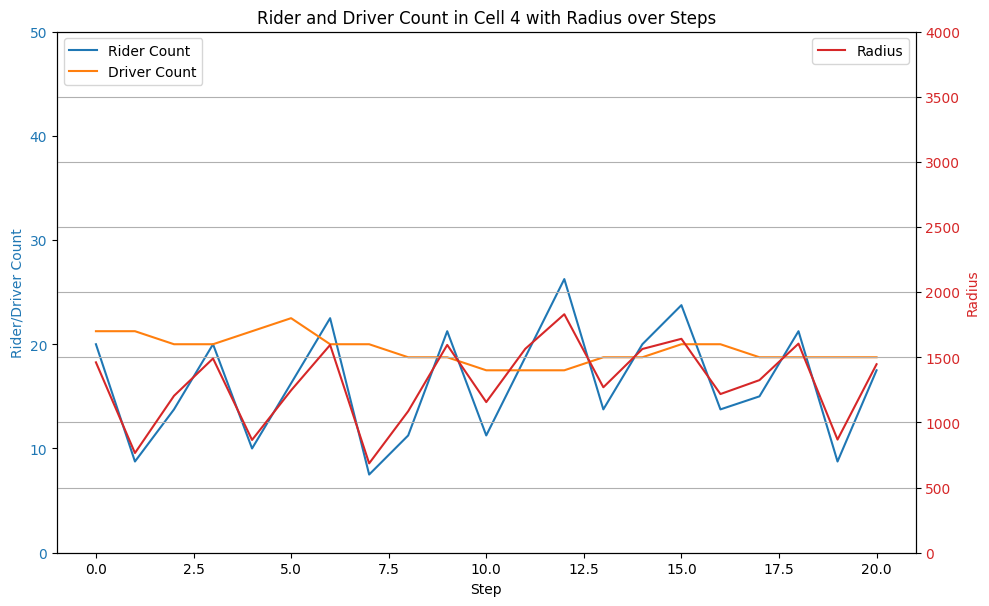

Drawing process done!


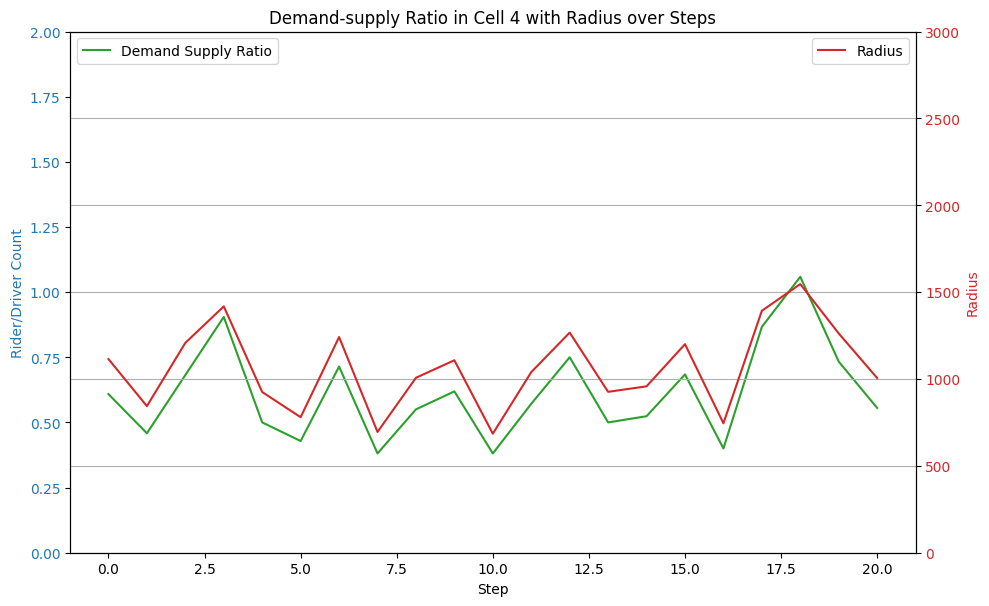

In [41]:
test.draw_trend(policy, 20, 16)
test.draw_ratio(policy, 20, 16)

In [11]:
perf_bl1, perf_bl2, perf_bl3, perf_bl4, perf_policy = test.run_test_performance(action_fr_1, action_fr_2, action_fr_3, action_fr_4, policy, 17)

Baseline test done!
Baseline test done!
Baseline test done!
Baseline test done!
Policy test done!


In [12]:
perf_bl1, perf_bl2, perf_bl3, perf_bl4, perf_policy

(array([  0.36773958, 319.02765092,   0.36773958]),
 array([  0.60586458, 572.19832559,   0.60586458]),
 array([7.52656250e-01, 7.74976274e+02, 7.52656250e-01]),
 array([8.28583333e-01, 9.49286612e+02, 8.28583333e-01]),
 array([7.85729167e-01, 8.82512263e+02, 7.85729167e-01]))

In [ ]:
cell = Cell(4)
cell.get_cells(True)

In [ ]:
env = RideHailingENV(4)
a = env.reset()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# load the trained policy from local
env = RideHailingENV(grid_div=4)
ddpg = DDPG(args)
loaded_policy = ddpg.actor
checkpoint = torch.load('./trained_policy/dynamic_radii_July_20_16cells.pth')
for model, state_dict in zip(policy, checkpoint):
    model.load_state_dict(state_dict)
print('Policy checkpoint loaded!')

In [ ]:
radius_b1 = np.array([]) # rate, distance, ult, this set is full balanced
radius_b2 = np.array([]) # 0.5 0.3 0.2
radius_b3 = np.array([]) # 0.5 0.2 0.3
radius_b4 = np.array([]) # 0.3 0.5 0.2
radius_b5 = np.array([]) # 0.3 0.2 0.5
radius_b6 = np.array([]) # 0.2 0.3 0.5
radius_b7 = np.array([]) # 0.2 0.5 0.3
radius_b8 = np.array([]) # 0.5 0.5 0.0
radius_b9 = np.array([]) # 0.5 0.0 0.5
radius_b10 = np.array([]) # 0.0 0.5 0.5
radius_s1 = np.ones(40)*3000 + np.random.normal(0, 10, 40) # only matching rate
radius_s2 = np.ones(40)*50 + np.random.normal(0, 10, 40) # only distance
radius_s3 = np.array([]) # only driver ult

env = RideHailingENV(4)
# run policy in test env for a whole day
action = np.zeros(env.cell_num)
state = env.reset(time_ini=18)
step = 0
done = False

rider_counts = np.array([])
driver_counts = np.array([])
radii = np.array([])

while not done and step <= 30:
    for i in range(env.cell_num):  # Since there are 16 cells
        # Check if there are neighbors defined for cell i in neighbors
        neighbors_i = ddpg.neighbors[i]
        state_i = state[i * 2 : (i + 1) * 2]
        outer = np.zeros(2)
        # Fill rider and driver counts for neighboring cells in state_i
        for j in range(1, len(neighbors_i)):  # Start from index 1 to skip the current cell itself
            neighbor = neighbors_i[j]
            if (neighbor != -1):  # If neighbor is not False (i.e., it's a valid index)
                neighbor_index = int(neighbor)
                outer[0] += state[neighbor_index * 2]
                outer[1] += state[(neighbor_index) * 2 + 1]
        state_i = np.concatenate((state_i, outer))
        action[i] = ddpg.get_action(policy[i], state_i).detach().numpy()[0]
    
    state_, reward, done = env.test_step(action, 18, min_max=True)
    radius = ddpg.get_radius(action)

    radius_b1 = np.append(radius_b1, radius[4])
    radius_b2 = np.append(radius_b2, radius[9])
    radius_b3 = np.append(radius_b3, radius[9] + 110)
    radius_b4 = np.append(radius_b4, radius[0])
    radius_b5 = np.append(radius_b5, radius[1])
    radius_b6 = np.append(radius_b6, radius[2])
    radius_b7 = np.append(radius_b7, radius[3] - 150)
    radius_b8 = np.append(radius_b8, radius[11])
    radius_b9 = np.append(radius_b9, radius[5])
    radius_b10 = np.append(radius_b10, radius[10])
    radius_s3 = np.append(radius_s3, radius[7])
    state = state_
    step += 1


In [ ]:
#radius_b4 -= 30
#radius_b5 -= 30
#radius_b7 -= 300
radius_b9 -= 150
#radius_b8 += 2000
#radius_b10 -= 150
#radius_s3 += 200


In [ ]:
# plot
data = [
    radius_b1, 
    radius_b2, 
    radius_b3, 
    radius_b4, 
    radius_b5, 
    radius_b6, 
    radius_b7, 
    radius_b8, 
    radius_b9, 
    radius_b10, 
    radius_s1,
    radius_s2,
    radius_s3
    ]

labels = [
    'bal_1', 
    'bal_2', 
    'bal_3',
    'bal_4',
    'bal_5',
    'bal_6',
    'bal_7',
    'bal_8',
    'bal_9',
    'bal_10',
    'sin_1', 
    'sin_2', 
    'sin_3'
]

labels_legend = [
    'bal_1: all weights are full balanced', 
    'bal_2: bias weights toward matching rate', 
    'bal_3: bias weights toward matching rate (disturb)',
    'bal_4: bias weights toward pick-up distance',
    'bal_5: bias weights toward pick-up distance (disturb)',
    'bal_6: bias weights toward driver utilization',
    'bal_7: bias weights toward driver utilization (disturb)',
    'bal_8: balanced weights without driver utilization',
    'bal_9: balanced weights without pick-up distance',
    'bal_10: balanced weights without matching rate',
    'sin_1: only considering matching rate', 
    'sin_2: only considering pick-up distance', 
    'sin_3: only considering driver utilization'
]

colors = [
    'green',        # radius_b1
    '#66c2ff',      # radius_b2 - Light Blue
    '#3399ff',      # radius_b3 - Medium Blue
    '#cccccc',      # radius_b4 - Light Grey
    '#999999',      # radius_b5 - Medium Grey
    '#ff9999',      # radius_b6 - Light Red
    '#ff6666',      # radius_b7 - Medium Red
    '#b3aaff',      # radius_b8 - Light Purple
    '#6a51a3',      # radius_b9 - Medium Purple
    '#3c009f',      # radius_b10 - Dark Purple
    '#ffd700',      # radius_s1 - Light Gold
    '#ffbf00',      # radius_s2 - Medium Gold
    '#ff9900'       # radius_s3 - Dark Gold
]

# 计算均值、标准差和置信区间
means = [np.mean(d) for d in data]
stds = [np.std(d) for d in data]
ci_95 = [norm.interval(0.95, loc=mean, scale=std/np.sqrt(len(d))) for mean, std, d in zip(means, stds, data)] 
ci_99 = [norm.interval(0.9999, loc=mean, scale=std/np.sqrt(len(d))) for mean, std, d in zip(means, stds, data)]

# 绘制均值和置信区间
plt.figure(figsize=(10, 6))

# 绘制均值的长方形和置信区间的上下横线
rectangle_width = 0.2
for i, (mean, ci95, ci99, label, color) in enumerate(zip(means, ci_95, ci_99, labels, colors)):
    rect_height = ci95[1] - ci95[0]  # 高度为95%置信区间
    plt.gca().add_patch(plt.Rectangle((i - rectangle_width / 2, ci95[0]), rectangle_width, rect_height, color=color, alpha=0.6))
    plt.errorbar(i, mean, yerr=[[mean - ci99[0]], [ci99[1] - mean]], fmt='o', color='black', ecolor=color, elinewidth=2, capsize=5)

plt.title('Weight Combination Sensitivity Analysis')
plt.xlabel('Weight Combinations')
plt.ylabel('Radius')
plt.xticks(range(len(labels)), labels)
plt.grid()

# 将图例放置在外部
plt.legend(labels_legend, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
ci_95

In [17]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
